by Alexey Gronskiy, ISE group, D-INFK, version of 12 Oct 2017

Tags **[TRY_IT_OUT]** are followed by cells, where you can play with the parameters of density estimators, as written in these cells' comments.

Requirements: matplolib, numpy, sklearn, scipy, seaborn

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, ListedColormap
from sklearn import mixture, neighbors, datasets
from scipy.stats import norm

import seaborn as sns
sns.set()
sns.set_context('poster', rc={'lines.markeredgewidth': 1.5, 
                            'lines.linewidth': 2.5,
                            'lines.markersize': 9,
                            'figure.figsize': [14, 8],
                            'font.size': 40})

plt.rcParams["figure.figsize"] = [14,8]
plt.rcParams.update({'font.size': 30})

# Parametric Density Estimation (Gaussian Mixture Model)

In [2]:
# Compute p.d.f. of joint Gaussian
def compute_pdf_of_gmm(x, means, sigmas, weights):
  """
  Args:
    x: array of points where to evaluate the pdf.
    means, sigmas, weights: 1-D arrays of length N representing
      the paramteres of Gaussians and the weights of mixture.
  """
  x = x.reshape(-1, 1)
  means = means.reshape(1, -1)
  sigmas = sigmas.reshape(1, -1)
  weights = weights.reshape(1, -1)
  
  pdfs = (1/(sigmas * np.sqrt(2 * np.pi)) 
          * np.exp(-(x - means)**2 / (2 * sigmas**2)))
  return np.sum(pdfs * weights, axis=1)

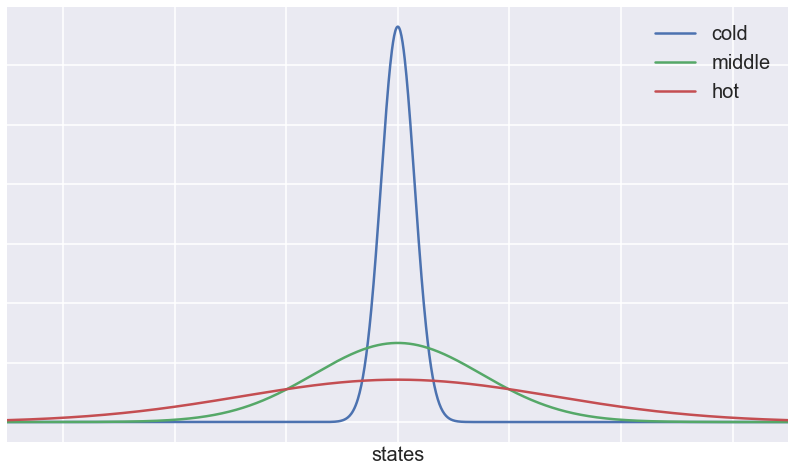

In [15]:
def plot_gmm_fitting():
  gaussian_means_sigmas_1 = np.array([
    [0, 0.3]
  ])
  gaussian_weights_1 = np.array([1])
  gaussian_weights_2 = np.array([1])
  
  gaussian_means_sigmas_2 = np.array([
    [0, 1.5]
  ])
  gaussian_weights_3 = np.array([1])

  gaussian_means_sigmas_3 = np.array([
    [0, 2.8]
  ])

  

  # np.random.seed(0)
  np.random.seed()

  # ==================================================== #

  # display predicted scores by the model as a contour plot
  X = np.linspace(-10, 10, num=2000).reshape(-1, 1)
  X_true_pdfs_1 = compute_pdf_of_gmm(
    X, 
    gaussian_means_sigmas_1[:, 0],
    gaussian_means_sigmas_1[:, 1],
    gaussian_weights_1)
  
  X_true_pdfs_2 = compute_pdf_of_gmm(
    X, 
    gaussian_means_sigmas_2[:, 0],
    gaussian_means_sigmas_2[:, 1],
    gaussian_weights_2)
  
  X_true_pdfs_3 = compute_pdf_of_gmm(
    X, 
    gaussian_means_sigmas_3[:, 0],
    gaussian_means_sigmas_3[:, 1],
    gaussian_weights_3)


  plt.figure()
  plt.plot(X, X_true_pdfs_1, label='cold')
  plt.plot(X, X_true_pdfs_2, label='middle')
  plt.plot(X, X_true_pdfs_3, label='hot')

  
  plt.legend(prop={'size': 20})
  plt.axis('tight')
  plt.gca().set_xlim([-7,7])
  plt.rc('axes', labelsize=20)
  plt.tick_params(    # changes apply to the x-axis
    labelbottom='off',
    labelleft='off') # labels along the bottom edge are off
  plt.xlabel('states', fontsize=20)
  
  plt.savefig('stable_and_unstable_distr_raw.eps', format='eps', dpi=300, bbox_inches='tight')
  plt.show()
plot_gmm_fitting()

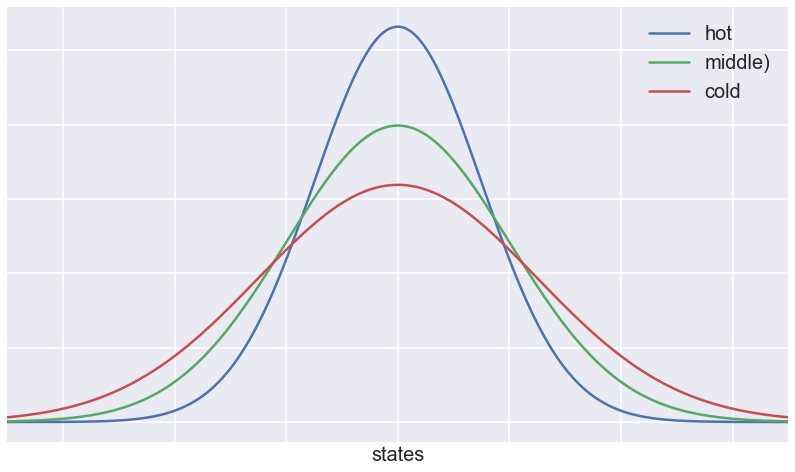

In [6]:
plot_gmm_fitting()

**[TRY_IT_OUT]**

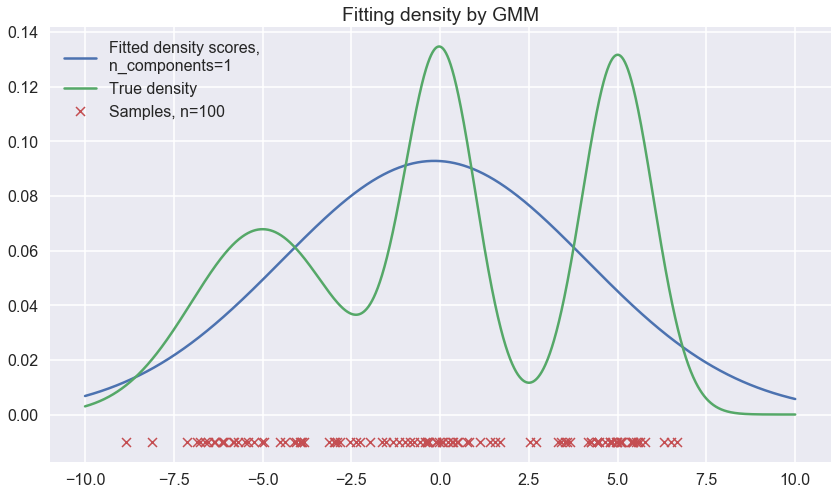

In [57]:
# Try to play with number of components (1, 2, 3, 5). How to overfit?

# If you set n_components = 15, which n_samples you will need to not looking 
# like you've overfitted? Try n_samples = 10, 100, 10000 and so on.

plot_gmm_fitting(n_samples=100, n_components=1)

# Non-parametric Density Estimation: Histograms

In [5]:
def draw_histogram(n_samples, n_bins):
  n_samples = int(n_samples)
  n_bins = int(n_bins)
  
  gaussian_means_sigmas = np.array([
    [-5, 2],
    [0, 1],
    [5, 1]
  ])
  gaussian_weights = np.array([.34, .33, .33])

  # np.random.seed(0)
  np.random.seed()

  # ==================================================== #

  samples = sample_from_gmm(
      n_samples,
      gaussian_means_sigmas[:, 0],
      gaussian_means_sigmas[:, 1],
      gaussian_weights
  )
  samples = samples.reshape(-1, 1)

  # display predicted scores by the model as a contour plot
  X = np.linspace(-10, 10, num=150).reshape(-1, 1)
  X_true_pdfs = compute_pdf_of_gmm(
    X, 
    gaussian_means_sigmas[:, 0],
    gaussian_means_sigmas[:, 1],
    gaussian_weights)

  # Here comes histogram
  bins = np.linspace(-10, 10, num=n_bins)

  plt.hist(samples, bins, normed=True, label='Histogram, bins={}'.format(n_bins))
  plt.plot(X, X_true_pdfs, label='True density')
  plt.plot(samples, np.zeros_like(samples) - 0.01, 'x',
           label='Samples, n={}'.format(n_samples))

  plt.title('Histograms')
  plt.legend()
  plt.axis('tight')

  plt.show()

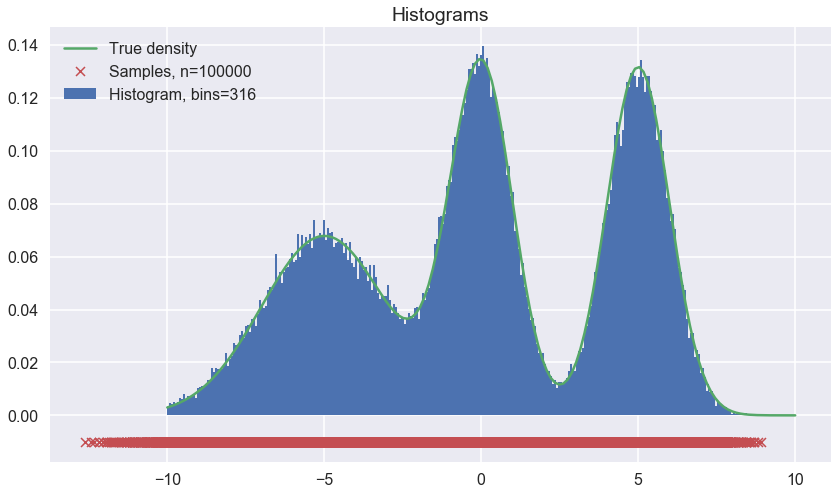

In [43]:
n_samples = 100000
n_bins = np.sqrt(n_samples)
draw_histogram(n_samples, n_bins)

**[TRY_IT_OUT]**

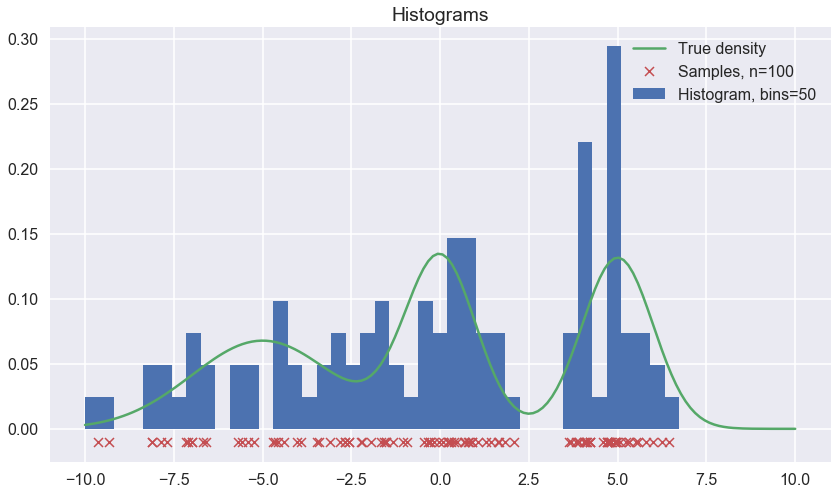

In [42]:
# Try to see what happens if you independently change number of bins and number of samples:
# n_samples = 10, 100, 1000
# n_bins = 10, 100, 1000, 10000
n_samples = 100
n_bins = 50
draw_histogram(n_samples, n_bins)

**[TRY_IT_OUT]**

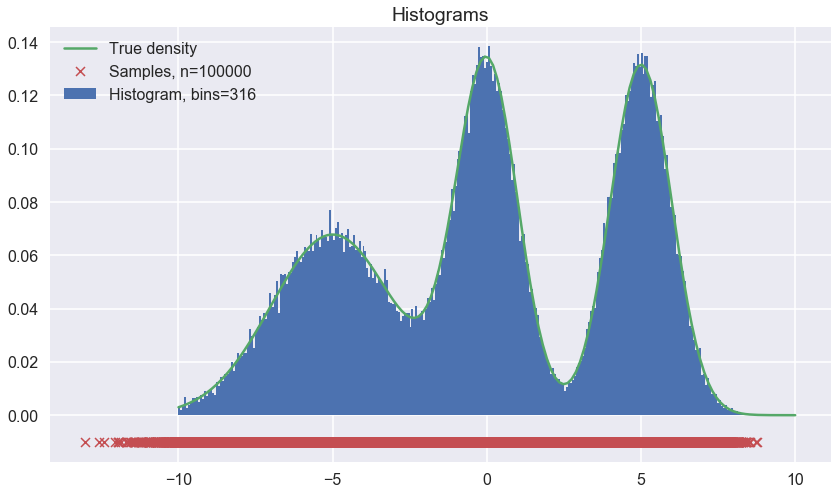

In [48]:
# Convince yourself that the basic rule of thumb n_bins = sqrt(n_samples) works, 
# increasing n_samples from 10, 100, 1000 to 100000
n_samples = 100000
n_bins = np.sqrt(n_samples)
draw_histogram(n_samples, n_bins)

# Non-parametric Estimation: Window Functions

Main idea - make bins 'movable', i.e. turn them into sliding windows.

In [6]:
# Helper function to print windows.
def print_window_fns(*window_fn_list):
  """
  Args: 
    window_fn_list: a list of arguments each representing a 
      function object (see cell below for its signature).
  """
  X = np.linspace(-5, 5, num=1500).reshape(-1, 1)
  
  for window_fn in window_fn_list: 
    fn_values = window_fn(X)
    plt.plot(X, fn_values, label='{}'.format(window_fn.__name__))

    plt.title('Window Fn\'s')
    plt.legend()
    plt.axis('equal')
    plt.xlim((-2, 2))
    plt.ylim((-0.2, 1.2))

  plt.show()

In [7]:
# Various window functions

def constant_window_fn(delta):
  delta = np.absolute(delta)
  output = np.ones_like(delta) * 0.5
  output[delta > 1.0] = 0.0
  return output

def gaussian_window_fn(delta):
  output = 1 / np.sqrt(2 * np.pi) * np.exp(-delta**2 / 2.0)
  return output

def epanechnikov_window_fn(delta):
  delta = np.absolute(delta)
  output = 0.75 * (1 - delta**2)
  output[delta > 1.0] = 0.0
  return output

def triangular_window_fn(delta):
  delta = np.absolute(delta)
  output = (1 - delta)
  output[delta > 1.0] = 0.0
  return output

def crazy_triangular_window_fn(delta):
  delta = np.absolute(delta)
  output = triangular_window_fn(delta * 2 - 1)
  return output

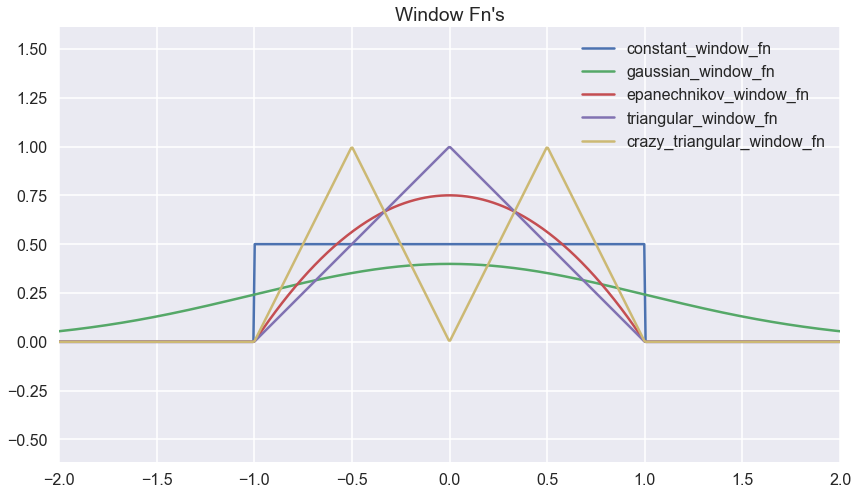

In [8]:
# See how they look like
print_window_fns(constant_window_fn, 
                 gaussian_window_fn, 
                 epanechnikov_window_fn,
                 triangular_window_fn,
                 crazy_triangular_window_fn)

In [9]:
def compute_window_estimation(x, samples, window_fn, h):
  """
  Args: 
    x: ndarray of shape `(S, 1)` with `S` points at which to compute the 
      estimation, or a scalar.
    samples: ndarray of shape `(N, 1)` with samples from the unknown 
      distribution.
    window_fn: function object representing window function with signature 
      (delta -> window_value).
    h: Parzen window width parameter.

  Returns:
    output: `(S, 1)` array of estimates.
    window_fn_values: `(S, N)` size where the values of each sample's window_fn
      are computed.
  """
  x = np.asarray(x).reshape(-1, 1)  # Shape (S, 1).
  samples = samples.T  # Shape (1, N).
  
  deltas = x - samples  # Shape (S, N).
  
  window_fn_values = (1 / (samples.size * h)) * window_fn(deltas / h)
  
  return (np.sum(window_fn_values, axis=1, keepdims=True), window_fn_values)

In [10]:
def window_estimation(window_fn, h, n_samples, print_separate=True):
  """
    Args: 
      window_fn: function object representing window function with signature 
        (delta -> window_value).
      h: Parzen window width parameter.
  """
  gaussian_means_sigmas = np.array([
    [-5, 2],
    [0, 1],
    [5, 1]
  ])
  gaussian_weights = np.array([.34, .33, .33])

  # np.random.seed(0)
  np.random.seed()

  # ==================================================== #

  samples = sample_from_gmm(
      n_samples,
      gaussian_means_sigmas[:, 0],
      gaussian_means_sigmas[:, 1],
      gaussian_weights
  )
  samples = samples.reshape(-1, 1)

  # display predicted scores by the model as a contour plot
  X = np.linspace(-10, 10, num=2000).reshape(-1, 1)
  X_true_pdfs = compute_pdf_of_gmm(
    X, 
    gaussian_means_sigmas[:, 0],
    gaussian_means_sigmas[:, 1],
    gaussian_weights)
  
  X_fitted, window_fn_values = compute_window_estimation(X, samples, window_fn, h)

  plt.plot(X, X_fitted, label='Fitted density')
  plt.plot(X, X_true_pdfs, label='True density')
  plt.plot(samples, np.zeros_like(samples) - 0.01, 'x', label='Samples')
  plt.title('Fitting density by \'{}\''.format(window_fn.__name__))
  plt.axis('tight')  
  if print_separate:
    for sample_idx in range(window_fn_values.shape[1]):
      separate, = plt.plot(X, window_fn_values[:, sample_idx] - 0.005, '--', color='black')
  handles, labels = plt.gca().get_legend_handles_labels()
  if print_separate:
    plt.legend(handles=handles + [separate], labels=labels + ['Separate windows'])
  plt.show() 

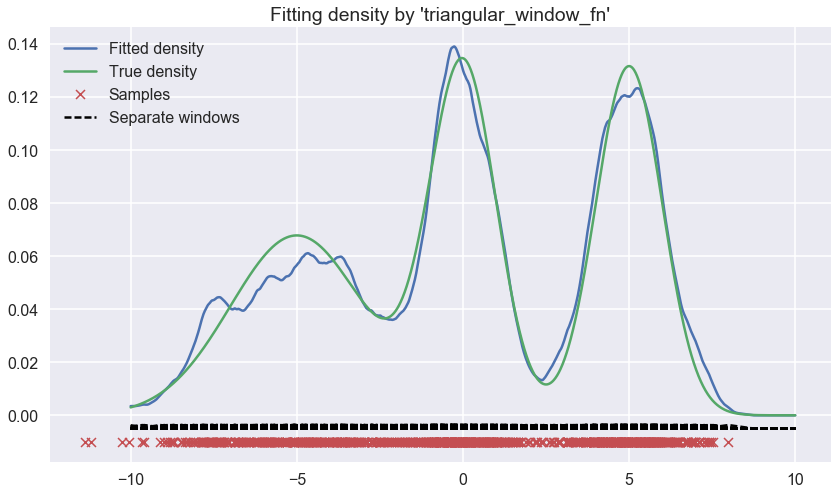

In [48]:
window_estimation(triangular_window_fn, h=.75, n_samples=1000)

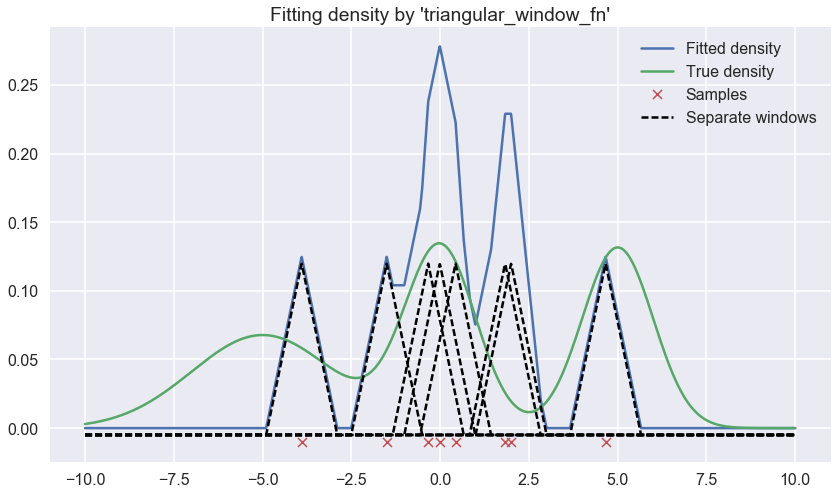

In [64]:
window_estimation(triangular_window_fn, h=1, n_samples=8)

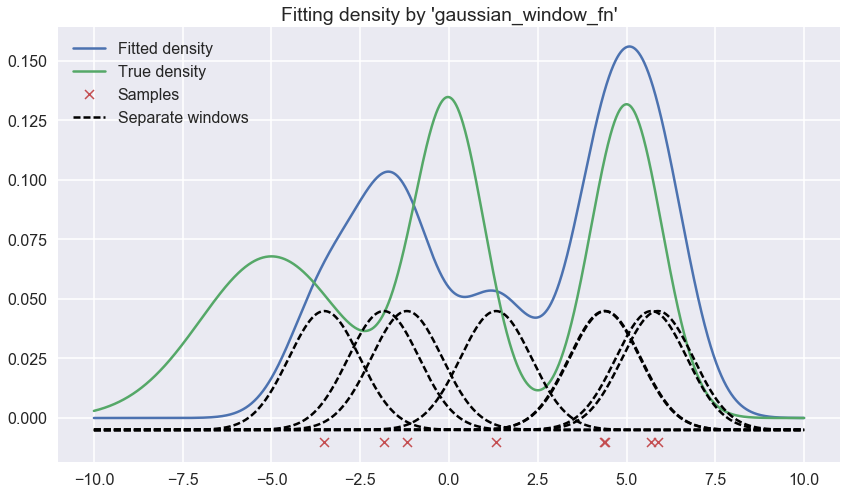

In [67]:
window_estimation(gaussian_window_fn, h=1, n_samples=8)

**[TRY_IT_OUT]**


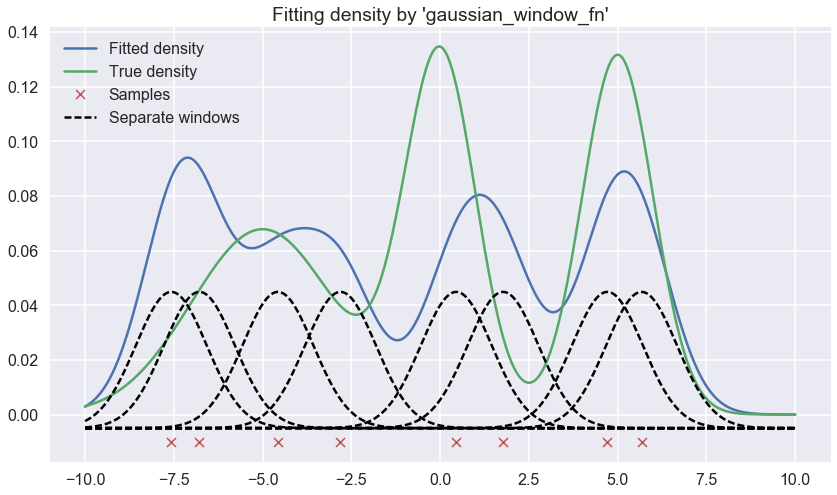

In [38]:
# Try to play with various window functions from this list:
# constant_window_fn, 
# gaussian_window_fn, 
# epanechnikov_window_fn,
# triangular_window_fn,
# crazy_triangular_window_fn

# Try to see what happens if you set low, normal ans high values of window:
# h = 0.05, 
# h = 0.5
# h = 1
# h = 3

# Try to see what happens if you increase the number of samples:
# n_samples = 5
# n_samples = 50
# n_samples = 500
# n_samples = 5000

window_estimation(gaussian_window_fn, h=1, n_samples=8)

**NB!** What matters is number of samples and window. In principle, form is less important, unless you need some additional properties like smoothness. 

You can obtain decent results even with 'crazy' windows like bi-modal triangular (attention, runs for about a minute), provided you have enough samples:

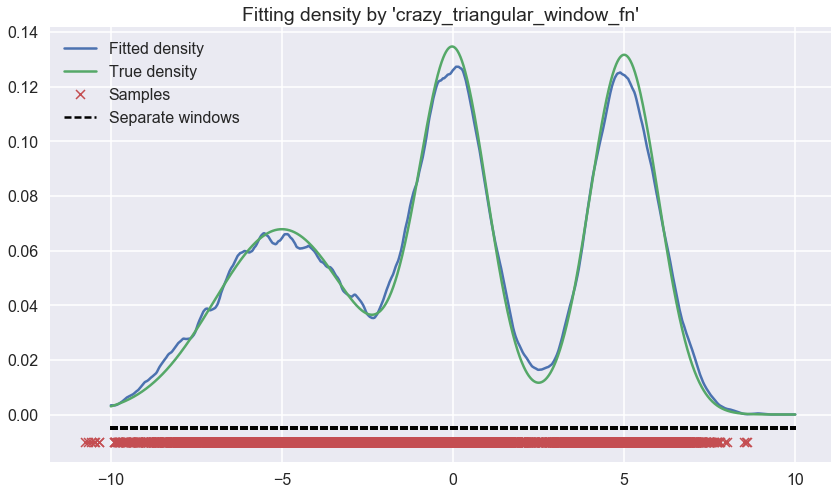

In [34]:
# This will also work!
window_estimation(crazy_triangular_window_fn, .7, 10000, True)

# Another view via convolution (see slides): empirical CDF

In [14]:
def draw_empirical_cdf(num_samples):
  num_samples = int(num_samples)
  
  X = np.linspace(-3, 3, num=600).reshape(-1, 1)
  cdf_true = norm.cdf(X)

  samples = np.random.randn(num_samples)
  samples = samples[samples >= -3]
  samples = samples[samples <= 3]
  samples_sorted = np.sort(samples)

  cdf_estimated = np.arange(len(samples_sorted))/float(len(samples_sorted))


  plt.plot(samples_sorted, cdf_estimated, 
           label='Empirical CDF, n={}'.format(num_samples))
  plt.plot(X, cdf_true, label='True Gaussian CDF')
    
  plt.title('Empirical CDF')
  plt.legend()
  plt.axis('tight')
 
  plt.show() 


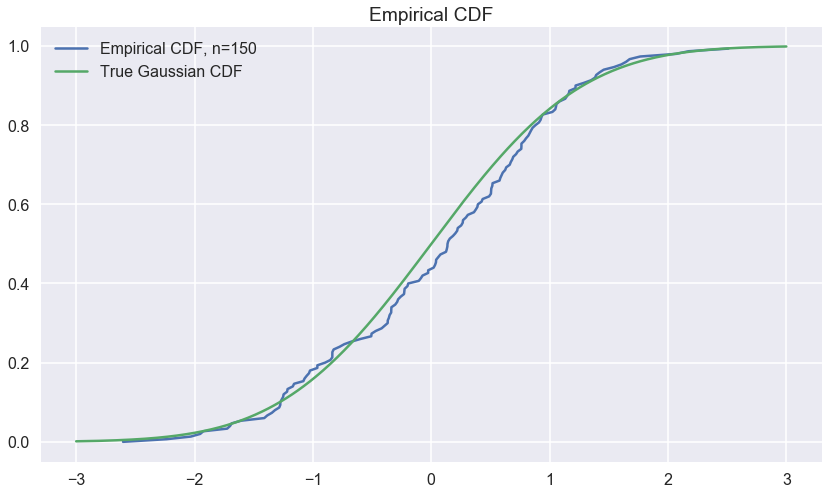

In [15]:
draw_empirical_cdf(num_samples=150)

# kNN Classifier (based on sklearn example)
http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html#sphx-glr-auto-examples-neighbors-plot-classification-py

In [11]:
def knn_classifier(n_neighbors, X, y):
  
  h = .01  # step size in the mesh

  # Create color maps
  cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF', '#B0B0B0'])
  cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF', '#A0A0A0'])

  # we create an instance of Neighbours Classifier and fit the data.
  clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
  clf.fit(X, y)

  # Plot the decision boundary. For that, we will assign a color to each
  # point in the mesh [x_min, x_max]x[y_min, y_max].
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                       np.arange(y_min, y_max, h))
  Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

  # Put the result into a color plot
  Z = Z.reshape(xx.shape)
  plt.figure()
  plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

  # Plot also the training points
  plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
              edgecolor='k', s=20)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())
  plt.title('kNN Classifier (k={})'.format(n_neighbors))

  plt.show()

In [12]:
# This cell creates dataset
def create_data_labels(class_size):
  covariance = np.array([[1, 0], [0, 1]]) * 2

  data_list = []
  labels_list = []

  data_list.append(np.random.multivariate_normal(mean=[2, 2], 
                                                 cov=covariance, 
                                                 size=(class_size,)))
  labels_list.append(np.ones((class_size, )) * 1)

  data_list.append(np.random.multivariate_normal(mean=[-2, -2], 
                                                 cov=covariance, 
                                                 size=(class_size,)))
  labels_list.append(np.ones((class_size, )) * 2)

  data_list.append(np.random.multivariate_normal(mean=[2, -2], 
                                                 cov=covariance, 
                                                 size=(class_size,)))
  labels_list.append(np.ones((class_size, )) * 3)

  data_list.append(np.random.multivariate_normal(mean=[-2, 2], 
                                                 cov=covariance, 
                                                 size=(class_size,)))
  labels_list.append(np.ones((class_size, )) * 4)

  return np.concatenate(data_list), np.concatenate(labels_list)

**[TRY_IT_OUT]**

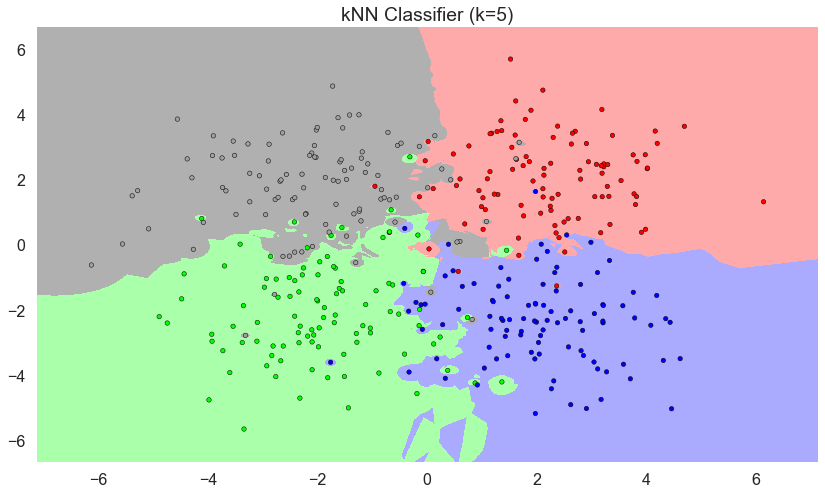

In [150]:
# In the situation of classes overlapping, see what happens to boundaries 
# if you increase n_neighbors = 2, 5, 10, 100.

# Play with class covariances and means above (less important)
X, y = create_data_labels(class_size=100)
knn_classifier(n_neighbors=5, X=X, y=y)